<a href="https://colab.research.google.com/github/Elhai12/SBA_loans_predict/blob/main/EDA_Data_Cleansing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
!pip install fancyimpute

In [111]:
!pip install missingno

In [68]:
#Clone git to get the files
!git clone https://github.com/Elhai12/SBA_loans_predict.git

fatal: destination path 'SBA_loans_predict' already exists and is not an empty directory.


In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
warnings.filterwarnings('ignore')

import time
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.subplots as sp
from scipy.stats import mannwhitneyu,chisquare,chi2_contingency
import plotly.express as px
from SBA_loans_predict import Functions_for_EDA
from scipy.stats import norm, ks_2samp
import missingno as msno
import fancyimpute
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

In [70]:
df = pd.read_pickle("/content/SBA_loans_predict/sba_loans_flat_pkl")

In [71]:
print(np.version.version)

2.0.2


In [72]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ApprovalFY,41212.0,2002.473915,4.985088,1971.0,1999.0,2004.0,2006.0,2014.0
Term,41212.0,110.743546,79.484949,0.0,60.0,84.0,120.0,360.0
NoEmp,41212.0,9.030452,23.316526,0.0,2.0,4.0,9.0,2100.0
CreateJob,41212.0,4.138406,130.405083,0.0,0.0,0.0,2.0,8800.0
RetainedJob,41212.0,6.163350,132.268420,0.0,0.0,1.0,4.0,8800.0
DisbursementGross,41212.0,206791.720834,307661.611129,0.0,35057.0,95442.5,243000.0,5000000.0
GrAppv,41212.0,198424.634767,309303.216333,2500.0,30000.0,75000.0,230000.0,5000000.0
SBA_Appv,41212.0,152805.400296,249756.329399,1500.0,17500.0,50000.0,180000.0,4500000.0
Month_apv,41212.0,6.541056,3.365058,1.0,4.0,7.0,9.0,12.0
Day_apv,41212.0,16.036616,8.724228,1.0,9.0,16.0,23.0,31.0


In [73]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()

#Outliers

##Outliers Detection

###Visual Detection

In [74]:
#Create grid of boxplot for eac numeric feature
fig = make_subplots(rows=3, cols=4, subplot_titles=num_cols)


for i, col in enumerate(num_cols):
    row, col_idx = divmod(i, 4)
    row += 1
    col_idx += 1

    box_fig = px.box(df, x=col, title=col)


    for trace in box_fig.data:
        fig.add_trace(trace, row=row, col=col_idx)
fig.show()

In [75]:
#Exploresion the specific outliers values
df[df['SBA_Appv']>=3500000]

,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,MIS_Status,GrAppv,SBA_Appv,Region,Is_Franchise,Category_bank,Sector_group,Month_apv,Day_apv,Diff_days
18648,2009,240,40,2.0,23,40,1,N,N,4000000.0,P I F,4000000.0,4000000.0,Central Florida,1,Other,"Culture, Leisure, and Restaurants",3,20,509.0
22902,2011,300,15,1.0,0,0,1,N,N,4068000.0,P I F,4068000.0,3661200.0,Central Florida,1,Commercial Bank,"Culture, Leisure, and Restaurants",12,28,63.0
24144,2011,12,32,1.0,0,32,1,Y,N,4000000.0,P I F,4000000.0,3600000.0,South Florida,1,Commercial Bank,Construction and Infrastructure,9,8,23.0
25180,2012,12,55,1.0,0,55,1,Y,N,4000000.0,P I F,4000000.0,3600000.0,South Florida,1,Commercial Bank,Manufacturing,3,14,0.0
26801,2013,2,65,1.0,5,65,1,Y,N,5000000.0,P I F,5000000.0,4500000.0,South Florida,1,Commercial Bank,Construction and Infrastructure,11,23,8.0
27999,2013,120,0,1.0,0,0,1,N,N,5000000.0,P I F,5000000.0,3750000.0,South Florida,1,Commercial Bank,Public Services and Health,2,11,18.0
28505,2013,12,27,1.0,5,27,1,Y,N,4000000.0,P I F,4000000.0,3600000.0,South Florida,1,Other,Construction and Infrastructure,3,13,0.0


In [76]:
df[df['Term']>=250]['MIS_Status'].value_counts()

,count
MIS_Status,
P I F,2945
CHGOFF,112


### Mathematical Detection

In [77]:
#I chose to identify outliers using the IQR method because, during the EDA, we observed that most of the features do not follow a normal distribution.

dict_outliers = {}
dict_range = {}
for col in num_cols:

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    dict_range[col] = [lower_limit, upper_limit]
    #Count number of rows that outliers
    num_outliers = df[(df[col] > upper_limit) | (df[col] < lower_limit)][col].count()
    #Count all rows
    all_obs = len(df[col])
    percent = round((num_outliers / all_obs)*100,2)

    dict_outliers[col] = [num_outliers, all_obs, percent]

df_outliers = pd.DataFrame.from_dict(dict_outliers, orient='index', columns=['num_outliers', 'all_obs', 'percent'])
df_outliers = df_outliers[df_outliers['percent']>0]
df_outliers

,num_outliers,all_obs,percent
ApprovalFY,241,41212,0.58
Term,7982,41212,19.37
NoEmp,4323,41212,10.49
CreateJob,4135,41212,10.03
RetainedJob,3756,41212,9.11
DisbursementGross,3991,41212,9.68
GrAppv,4228,41212,10.26
SBA_Appv,4315,41212,10.47
Diff_days,4296,41212,10.42


In [78]:
df_copy = df.copy()
df_copy['MIS_Status'] = df_copy['MIS_Status'].map({'P I F':1,'CHGOFF':0}).astype('category')

df_temp = df.copy()
df_temp['MIS_Status'] = df_temp['MIS_Status'].map({'P I F':1,'CHGOFF':0}).astype('category')
for col in df_outliers.index:
  #Get the upper and lower limit from dictionary of ranges was created above
    upper_limit = dict_range[col][1]
    lower_limit = dict_range[col][0]
    df_temp[col] = np.where(df_temp[col] > upper_limit,np.nan,np.where(df_temp[col] < lower_limit,np.nan,df_temp[col]))

df_temp

,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,MIS_Status,GrAppv,SBA_Appv,Region,Is_Franchise,Category_bank,Sector_group,Month_apv,Day_apv,Diff_days
0,1997.0,NaN,14.0,1.0,NaN,7.0,0,N,N,229000.0,1.0,229000.0,229000.0,East Florida,1,Other,NaN,2,28,75.0
1,1997.0,84.0,1.0,2.0,0.0,0.0,0,N,Y,45000.0,1.0,45000.0,36000.0,South Florida,1,Commercial Bank,"Culture, Leisure, and Restaurants",2,28,NaN
2,1997.0,NaN,2.0,2.0,0.0,0.0,0,N,N,305000.0,1.0,305000.0,228750.0,Central Florida,1,Commercial Bank,"Culture, Leisure, and Restaurants",2,28,153.0
3,1997.0,87.0,2.0,1.0,0.0,0.0,0,N,N,70000.0,1.0,70000.0,56000.0,South Florida,1,Other,Public Services and Health,2,28,184.0
4,2006.0,84.0,4.0,1.0,0.0,4.0,1,Y,N,51440.0,1.0,35000.0,17500.0,South Florida,1,Other,Construction and Infrastructure,2,7,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41207,1997.0,60.0,15.0,1.0,0.0,0.0,0,N,Y,95000.0,1.0,95000.0,76000.0,Central Florida,1,Other,NaN,2,25,187.0
41208,1997.0,84.0,2.0,2.0,0.0,0.0,0,N,Y,20000.0,1.0,20000.0,16000.0,North Florida,1,Commercial Bank,NaN,2,25,34.0
41209,1997.0,60.0,NaN,2.0,0.0,0.0,0,N,N,145000.0,1.0,145000.0,108750.0,South Florida,1,Commercial Bank,NaN,2,26,NaN
41210,1997.0,NaN,NaN,1.0,0.0,0.0,0,0,N,NaN,1.0,NaN,NaN,East Florida,1,Commercial Bank,Manufacturing,2,26,33.0


##Check the impact

In [79]:
#Function to compare the corr between the two population and target feature.
#Use this function to compare between the corr before the change the outliers to drop and after.
def cocor(x_before,y_before, x_after,y_after):

   #Use 'spearman' method beacuase the distribution not normal
    xy_corr_before = x_before.corr(y_before, method='spearman')
    xy_corr_after = x_after.corr(y_after, method='spearman')
    n1 = len(x_before)
    n2 = len(x_after)
    z_corr_before = 0.5 * np.log((1 + xy_corr_before)/(1 - xy_corr_before))
    z_corr_after = 0.5 * np.log((1 + xy_corr_after)/(1 - xy_corr_after))
    if n2 is None:
        n2 = n1
    se_diff_r = np.sqrt(1/(n1 - 3) + 1/(n2 - 3))
    diff = z_corr_before - z_corr_after
    z = abs(diff / se_diff_r)
    p = (1 - norm.cdf(z)) * 2
    return z, p

In [80]:
list_indicate_change = []
for col in df_outliers.index:
  x_all_data = df_copy[col]
  y_all_data = df_copy['MIS_Status']
  x_non_outliers = df_temp[col]
  y_non_outliers = df_temp['MIS_Status']
  p, pval = cocor(x_all_data,y_all_data,x_non_outliers,y_non_outliers)

  cor_change = np.where(pval < 0.05, '+', '-')
  # Outliers count and percent
  cnt_outliers = df_outliers.loc[col,'num_outliers']
  prc_outliers = df_outliers.loc[col,'percent']

  num_otliers = str(cnt_outliers) + ' (' + str(prc_outliers) + '%)'

  # KS test p-value for check change in distribution
  pval = ks_2samp(x_all_data, x_non_outliers)[1]
  dist_change = np.where(pval < 0.05, '+', '-')

  # Append the data as a dictionary
  list_indicate_change.append({
      'feature': col,
      'outliers_cnt': num_otliers,
      'distribution_changed': dist_change,
      'correlation_changed': cor_change

  })

df_indicate = pd.DataFrame(list_indicate_change)
df_indicate['drop'] = np.where((df_indicate['distribution_changed']=='+') & (df_indicate['correlation_changed']=='+'),'no','yes')
df_indicate

,feature,outliers_cnt,distribution_changed,correlation_changed,drop
0,ApprovalFY,241 (0.58%),-,+,yes
1,Term,7982 (19.37%),-,+,yes
2,NoEmp,4323 (10.49%),-,+,yes
3,CreateJob,4135 (10.03%),-,+,yes
4,RetainedJob,3756 (9.11%),-,+,yes
5,DisbursementGross,3991 (9.68%),-,+,yes
6,GrAppv,4228 (10.26%),-,+,yes
7,SBA_Appv,4315 (10.47%),-,+,yes
8,Diff_days,4296 (10.42%),-,+,yes


##Treatment of the outliers

In [81]:
features_change_outliers = df_indicate[df_indicate['drop']=='yes']['feature'].tolist()
features_change_outliers

['ApprovalFY',
 'Term',
 'NoEmp',
 'CreateJob',
 'RetainedJob',
 'DisbursementGross',
 'GrAppv',
 'SBA_Appv',
 'Diff_days']

In [82]:
df_manipulated = df_copy.copy()
#Change the outliers to Nan
for col in features_change_outliers:
  upper_limit = dict_range[col][1]
  lower_limit = dict_range[col][0]
  df_manipulated[col] = np.where(df_manipulated[col] > upper_limit,np.nan,np.where(df_manipulated[col] < lower_limit,np.nan,df_manipulated[col]))



In [83]:
df_manipulated.to_pickle("manipulated_data.pkl")

#Missing Values

##Detection

<Axes: >

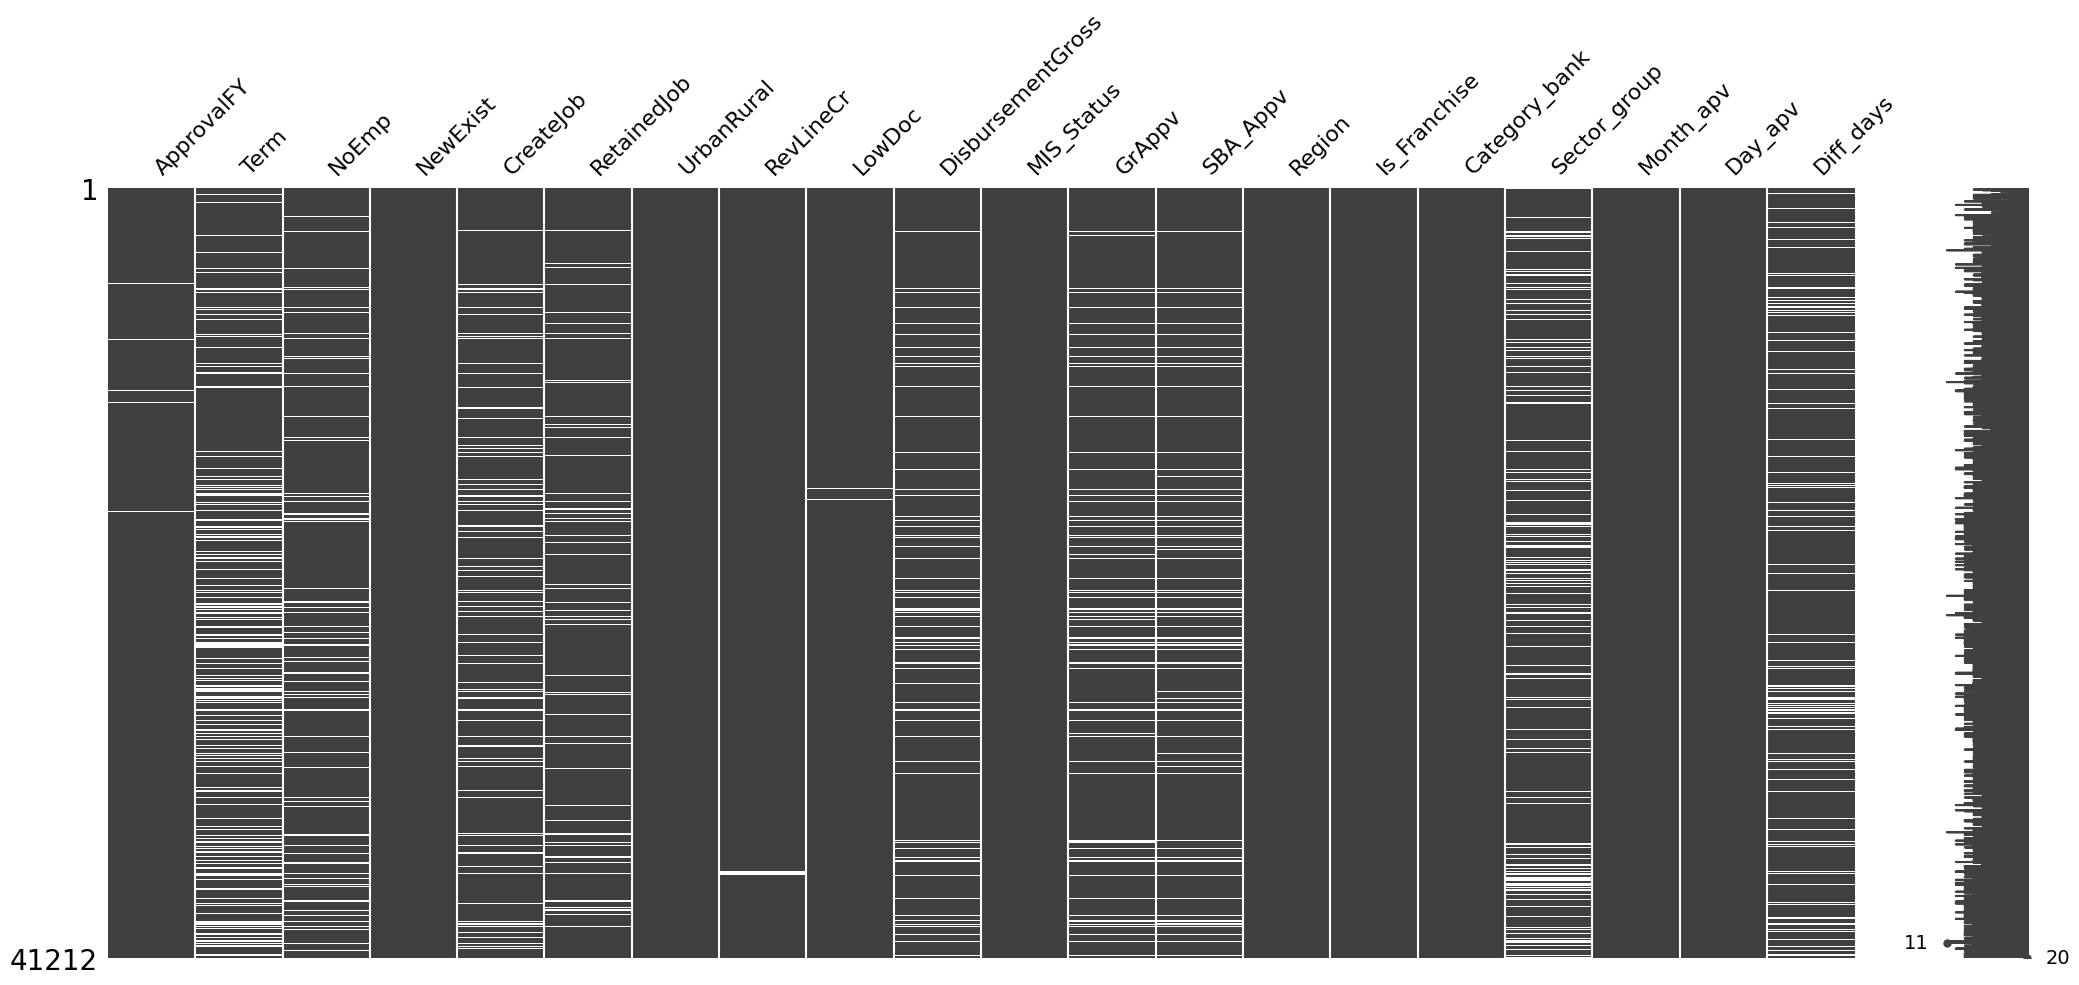

In [113]:
msno.matrix(df_manipulated)

<Axes: >

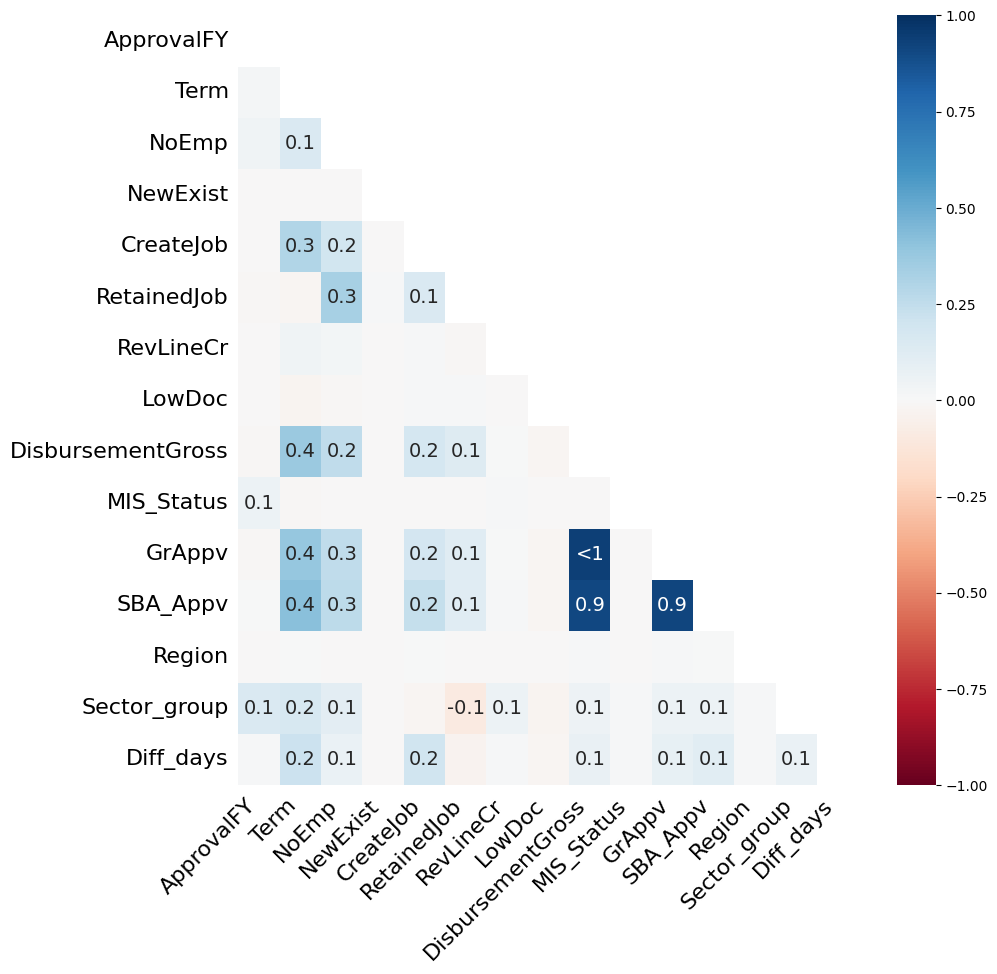

In [114]:
cols_missing = df_manipulated.columns[df_manipulated.isnull().any()].tolist()
msno.heatmap(df_manipulated[cols_missing], figsize=(10,10))

In [86]:
df_null = pd.DataFrame(df_manipulated.isna().sum(), columns=['cnt_null'])
df_null['percent'] = round((df_null['cnt_null']/len(df_manipulated))*100,2)
df_null = df_null[df_null['cnt_null']>0].sort_values(by='percent', ascending=False)
df_null


,cnt_null,percent
Term,7982,19.37
Sector_group,6616,16.05
Diff_days,4448,10.79
NoEmp,4323,10.49
SBA_Appv,4315,10.47
GrAppv,4228,10.26
CreateJob,4135,10.03
DisbursementGross,3991,9.68
RetainedJob,3756,9.11
ApprovalFY,241,0.58


##Fill missings

In [100]:
#Use MICE for numarical features and KNN for category features
num_cols = df_manipulated.select_dtypes(include=np.number).columns.tolist()
cat_cols = df_manipulated.select_dtypes(exclude=np.number).columns.tolist()

df_codes = df_manipulated.copy()

#For imputer - change the strings columns to decodes (without MIS_Status that changed alardy)
#And save the codes and category for reverse after to orignal values
mappings = {}

for col in [c for c in cat_cols if c != 'MIS_Status']:

    df_codes[col] = df[col].astype('category')
    mappings[col] = dict(enumerate(df_codes[col].cat.categories))
    df_codes[col] = df_codes[col].cat.codes.replace(-1, np.nan)




['NewExist',
 'UrbanRural',
 'RevLineCr',
 'LowDoc',
 'MIS_Status',
 'Region',
 'Is_Franchise',
 'Category_bank',
 'Sector_group']

In [88]:
mappings['Region']

{0: 'Central Florida',
 1: 'East Florida',
 2: 'North Florida',
 3: 'South Florida',
 4: 'West Florida'}

In [89]:
X= df_codes.copy()


#Fit the KNN on all data
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)
#Get only the category columns that fill
X_imputed_cat = pd.DataFrame(X_imputed,columns=X.columns)
X_imputed_cat = X_imputed_cat[cat_cols].round().astype(int)

X_imputed_cat

,NewExist,UrbanRural,RevLineCr,LowDoc,MIS_Status,Region,Is_Franchise,Category_bank,Sector_group
0,1,0,1,2,1,1,0,5,5
1,2,0,1,5,1,3,0,1,2
2,2,0,1,2,1,0,0,1,2
3,1,0,1,2,1,3,0,5,8
4,1,1,3,2,1,3,0,5,1
...,...,...,...,...,...,...,...,...,...
41207,1,0,1,5,1,0,0,5,2
41208,2,0,1,5,1,2,0,1,4
41209,2,0,1,2,1,3,0,1,5
41210,1,0,0,2,1,1,0,1,5


In [90]:
#Check if have Null's after the KNN imputer
X_imputed_cat.isna().sum()

,0
NewExist,0
UrbanRural,0
RevLineCr,0
LowDoc,0
MIS_Status,0
Region,0
Is_Franchise,0
Category_bank,0
Sector_group,0


In [104]:
#Check if add additonal category and if the dist very change
print("New DataFrame")
print(X_imputed_cat.describe().T)
print("****"*30)
print("Original DataFrame")
print(df_codes[cat_cols].describe().T)

New DataFrame
                 count      mean       std  min  25%  50%  75%  max
NewExist       41212.0  1.271984  0.445750  0.0  1.0  1.0  2.0  2.0
UrbanRural     41212.0  0.863996  0.584736  0.0  1.0  1.0  1.0  2.0
RevLineCr      41212.0  1.342934  1.165205  0.0  0.0  1.0  3.0  3.0
LowDoc         41212.0  2.283898  0.877827  0.0  2.0  2.0  2.0  5.0
MIS_Status     41212.0  0.726439  0.445792  0.0  0.0  1.0  1.0  1.0
Region         41212.0  2.319276  1.222846  0.0  2.0  3.0  3.0  4.0
Is_Franchise   41212.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Category_bank  41212.0  1.947442  1.754165  0.0  1.0  1.0  3.0  5.0
Sector_group   41212.0  3.874624  2.757934  0.0  1.0  3.0  7.0  9.0
************************************************************************************************************************
Original DataFrame
                 count      mean       std  min  25%  50%  75%  max
NewExist       41207.0  1.271968  0.445742  0.0  1.0  1.0  2.0  2.0
UrbanRural     41212.0  0.8639

In [92]:
#Check specific exemple
df_codes[df_codes['Region'].isna()]

,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,MIS_Status,GrAppv,SBA_Appv,Region,Is_Franchise,Category_bank,Sector_group,Month_apv,Day_apv,Diff_days
826,2006.0,NaN,2.0,1.0,4.0,0.0,2,0.0,2.0,308000.0,1.0,308000.0,308000.0,NaN,0,5,1.0,2,17,NaN
2270,1997.0,NaN,15.0,2.0,0.0,0.0,0,0.0,2.0,NaN,0.0,NaN,NaN,NaN,0,5,NaN,4,30,214.0
4933,1997.0,NaN,2.0,2.0,0.0,0.0,0,0.0,2.0,NaN,0.0,NaN,NaN,NaN,0,5,NaN,9,3,58.0
5641,1998.0,NaN,3.0,1.0,0.0,0.0,0,0.0,2.0,280000.0,1.0,280000.0,210000.0,NaN,0,1,NaN,10,10,82.0
6601,1998.0,29.0,4.0,2.0,0.0,0.0,0,1.0,5.0,35000.0,0.0,35000.0,28000.0,NaN,0,1,NaN,12,11,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40316,1996.0,13.0,7.0,1.0,0.0,0.0,0,3.0,2.0,15000.0,0.0,15000.0,7500.0,NaN,0,1,1.0,8,16,NaN
40544,1996.0,9.0,8.0,1.0,0.0,0.0,0,3.0,2.0,18577.0,0.0,25000.0,12500.0,NaN,0,1,2.0,9,27,126.0
41002,1997.0,NaN,2.0,1.0,0.0,0.0,0,1.0,5.0,65000.0,1.0,65000.0,52000.0,NaN,0,1,2.0,12,20,NaN
41074,2006.0,NaN,NaN,1.0,NaN,0.0,2,0.0,2.0,NaN,1.0,NaN,NaN,NaN,0,5,5.0,2,6,191.0


In [93]:
X_imputed_cat.loc[2270]

,2270
NewExist,2
UrbanRural,0
RevLineCr,0
LowDoc,2
MIS_Status,0
Region,2
Is_Franchise,0
Category_bank,5
Sector_group,5


In [105]:
#Reverse to category values for will treat in feature engineering stage (without MIS_Status)
X_revers_cat = X_imputed_cat.copy()
for col in [c for c in cat_cols if c != 'MIS_Status']:
  X_revers_cat[col] = X_revers_cat[col].astype(int)
  X_revers_cat[col] = X_revers_cat[col].map(mappings[col])
X_revers_cat

,NewExist,UrbanRural,RevLineCr,LowDoc,MIS_Status,Region,Is_Franchise,Category_bank,Sector_group
0,1.0,0,N,N,1,East Florida,1,Other,Manufacturing
1,2.0,0,N,Y,1,South Florida,1,Commercial Bank,"Culture, Leisure, and Restaurants"
2,2.0,0,N,N,1,Central Florida,1,Commercial Bank,"Culture, Leisure, and Restaurants"
3,1.0,0,N,N,1,South Florida,1,Other,Public Services and Health
4,1.0,1,Y,N,1,South Florida,1,Other,Construction and Infrastructure
...,...,...,...,...,...,...,...,...,...
41207,1.0,0,N,Y,1,Central Florida,1,Other,"Culture, Leisure, and Restaurants"
41208,2.0,0,N,Y,1,North Florida,1,Commercial Bank,Information and Communication
41209,2.0,0,N,N,1,South Florida,1,Commercial Bank,Manufacturing
41210,1.0,0,0,N,1,East Florida,1,Commercial Bank,Manufacturing


In [95]:
df_manipulated[cat_cols].loc[0:4]

,NewExist,UrbanRural,RevLineCr,LowDoc,MIS_Status,Region,Is_Franchise,Category_bank,Sector_group
0,1.0,0,N,N,1.0,East Florida,1,Other,NaN
1,2.0,0,N,Y,1.0,South Florida,1,Commercial Bank,"Culture, Leisure, and Restaurants"
2,2.0,0,N,N,1.0,Central Florida,1,Commercial Bank,"Culture, Leisure, and Restaurants"
3,1.0,0,N,N,1.0,South Florida,1,Other,Public Services and Health
4,1.0,1,Y,N,1.0,South Florida,1,Other,Construction and Infrastructure


In [106]:
#Use MICE for numeric features

X_imputed_num = fancyimpute.IterativeImputer(max_iter=15).fit_transform(X)
X_imputed_num = pd.DataFrame(X_imputed,columns=X.columns)
X_imputed_num = X_imputed_num[num_cols]
X_imputed_num

,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,GrAppv,SBA_Appv,Month_apv,Day_apv,Diff_days
0,1997.0,130.0,14.0,0.8,7.0,229000.0,229000.0,229000.0,2.0,28.0,75.0
1,1997.0,84.0,1.0,0.0,0.0,45000.0,45000.0,36000.0,2.0,28.0,100.0
2,1997.0,101.8,2.0,0.0,0.0,305000.0,305000.0,228750.0,2.0,28.0,153.0
3,1997.0,87.0,2.0,0.0,0.0,70000.0,70000.0,56000.0,2.0,28.0,184.0
4,2006.0,84.0,4.0,0.0,4.0,51440.0,35000.0,17500.0,2.0,7.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...
41207,1997.0,60.0,15.0,0.0,0.0,95000.0,95000.0,76000.0,2.0,25.0,187.0
41208,1997.0,84.0,2.0,0.0,0.0,20000.0,20000.0,16000.0,2.0,25.0,34.0
41209,1997.0,60.0,6.4,0.0,0.0,145000.0,145000.0,108750.0,2.0,26.0,125.2
41210,1997.0,58.4,6.4,0.0,0.0,207500.0,207500.0,187081.6,2.0,26.0,33.0


In [107]:
#Check if have Null's after the MICE
X_imputed_num.isna().sum()

,0
ApprovalFY,0
Term,0
NoEmp,0
CreateJob,0
RetainedJob,0
DisbursementGross,0
GrAppv,0
SBA_Appv,0
Month_apv,0
Day_apv,0


In [108]:
#Check if not add additonal category and if the dist very change
print("New DataFrame")
print(X_imputed_num.describe().T)
print("****"*30)
print("Original DataFrame")
print(df_codes[num_cols].describe().T)

New DataFrame
                     count           mean            std     min      25%  \
ApprovalFY         41212.0    2002.557148       4.793664  1989.0   1999.0   
Term               41212.0      81.608527      35.229986     0.0     60.0   
NoEmp              41212.0       5.230156       4.083032     0.0      2.0   
CreateJob          41212.0       0.680768       1.221956     0.0      0.0   
RetainedJob        41212.0       1.873047       2.516662     0.0      0.0   
DisbursementGross  41212.0  137524.062128  130562.599958     0.0  35000.0   
GrAppv             41212.0  127783.370028  129162.283988  2500.0  30000.0   
SBA_Appv           41212.0   96519.995700  105530.679177  1500.0  17500.0   
Month_apv          41212.0       6.541056       3.365058     1.0      4.0   
Day_apv            41212.0      16.036616       8.724228     1.0      9.0   
Diff_days          41212.0      61.084805      47.422301   -21.0     25.0   

                       50%        75%       max  
ApprovalFY 

In [109]:
#Union the number features df was fill by MICE with Categoty features df
df_final_fill_missing = pd.concat([X_imputed_num, X_revers_cat], axis=1)
df_final_fill_missing

,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,GrAppv,SBA_Appv,Month_apv,Day_apv,Diff_days,NewExist,UrbanRural,RevLineCr,LowDoc,MIS_Status,Region,Is_Franchise,Category_bank,Sector_group
0,1997.0,130.0,14.0,0.8,7.0,229000.0,229000.0,229000.0,2.0,28.0,75.0,1.0,0,N,N,1,East Florida,1,Other,Manufacturing
1,1997.0,84.0,1.0,0.0,0.0,45000.0,45000.0,36000.0,2.0,28.0,100.0,2.0,0,N,Y,1,South Florida,1,Commercial Bank,"Culture, Leisure, and Restaurants"
2,1997.0,101.8,2.0,0.0,0.0,305000.0,305000.0,228750.0,2.0,28.0,153.0,2.0,0,N,N,1,Central Florida,1,Commercial Bank,"Culture, Leisure, and Restaurants"
3,1997.0,87.0,2.0,0.0,0.0,70000.0,70000.0,56000.0,2.0,28.0,184.0,1.0,0,N,N,1,South Florida,1,Other,Public Services and Health
4,2006.0,84.0,4.0,0.0,4.0,51440.0,35000.0,17500.0,2.0,7.0,21.0,1.0,1,Y,N,1,South Florida,1,Other,Construction and Infrastructure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41207,1997.0,60.0,15.0,0.0,0.0,95000.0,95000.0,76000.0,2.0,25.0,187.0,1.0,0,N,Y,1,Central Florida,1,Other,"Culture, Leisure, and Restaurants"
41208,1997.0,84.0,2.0,0.0,0.0,20000.0,20000.0,16000.0,2.0,25.0,34.0,2.0,0,N,Y,1,North Florida,1,Commercial Bank,Information and Communication
41209,1997.0,60.0,6.4,0.0,0.0,145000.0,145000.0,108750.0,2.0,26.0,125.2,2.0,0,N,N,1,South Florida,1,Commercial Bank,Manufacturing
41210,1997.0,58.4,6.4,0.0,0.0,207500.0,207500.0,187081.6,2.0,26.0,33.0,1.0,0,0,N,1,East Florida,1,Commercial Bank,Manufacturing


In [110]:
df_final_fill_missing.to_pickle("manipulated_data.pkl")